=== Linear SVM Results ===
              precision    recall  f1-score   support

           0       0.97      0.96      0.96        71
           1       0.93      0.95      0.94        43

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114


=== RBF SVM Results ===
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        71
           1       1.00      0.95      0.98        43

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

Linear SVM CV Accuracy: 0.9692
RBF SVM CV Accuracy: 0.9758


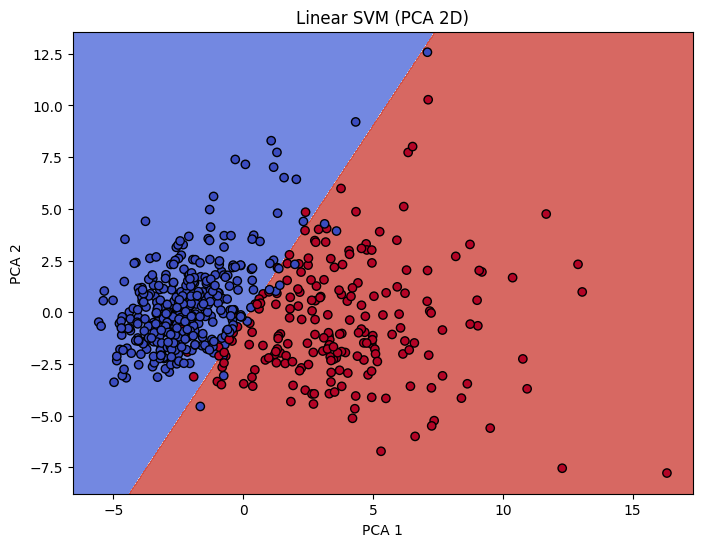

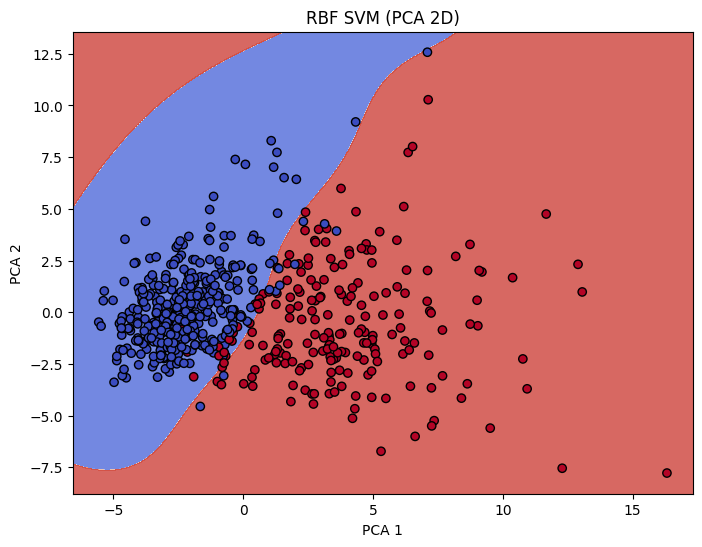

In [4]:
# svm_breast_cancer.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# ===================== 1. LOAD DATA =====================
# Make sure 'breast_cancer.csv' is in the same folder
df = pd.read_csv("E:/t3/breast-cancer.csv")

# Drop unnecessary columns
if 'id' in df.columns:
    df.drop(columns=['id'], inplace=True)
if 'Unnamed: 32' in df.columns:
    df.drop(columns=['Unnamed: 32'], inplace=True)

# Encode diagnosis: M = 1 (Malignant), B = 0 (Benign)
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

# ===================== 2. SPLIT & SCALE =====================
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ===================== 3. LINEAR SVM =====================
linear_svm = SVC(kernel='linear', C=1.0)
linear_svm.fit(X_train_scaled, y_train)
y_pred_linear = linear_svm.predict(X_test_scaled)

print("=== Linear SVM Results ===")
print(classification_report(y_test, y_pred_linear))

# ===================== 4. RBF SVM + TUNING =====================
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.001]
}
rbf_grid = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5)
rbf_grid.fit(X_train_scaled, y_train)
best_rbf = rbf_grid.best_estimator_

y_pred_rbf = best_rbf.predict(X_test_scaled)

print("\n=== RBF SVM Results ===")
print(classification_report(y_test, y_pred_rbf))

# ===================== 5. CROSS-VALIDATION =====================
linear_scores = cross_val_score(linear_svm, X_train_scaled, y_train, cv=5)
rbf_scores = cross_val_score(best_rbf, X_train_scaled, y_train, cv=5)

print(f"Linear SVM CV Accuracy: {linear_scores.mean():.4f}")
print(f"RBF SVM CV Accuracy: {rbf_scores.mean():.4f}")

# ===================== 6. PCA FOR VISUALIZATION =====================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaler.fit_transform(X))

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, random_state=42)

linear_pca = SVC(kernel='linear', C=1.0).fit(X_train_pca, y_train_pca)
rbf_pca = SVC(kernel='rbf', C=best_rbf.C, gamma=best_rbf.gamma).fit(X_train_pca, y_train_pca)

# ===================== 7. PLOT DECISION BOUNDARIES =====================
def plot_decision_boundary(clf, X, y, title, filename):
    h = .02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.title(title)
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.savefig(filename)
    plt.show()

plot_decision_boundary(linear_pca, X_pca, y, "Linear SVM (PCA 2D)", "decision_boundary_linear.png")
plot_decision_boundary(rbf_pca, X_pca, y, "RBF SVM (PCA 2D)", "decision_boundary_rbf.png")
